In [1]:
from google.colab import files
uploaded = files.upload()

Saving scan_images.zip to scan_images.zip


In [6]:
!pip install pyswarm

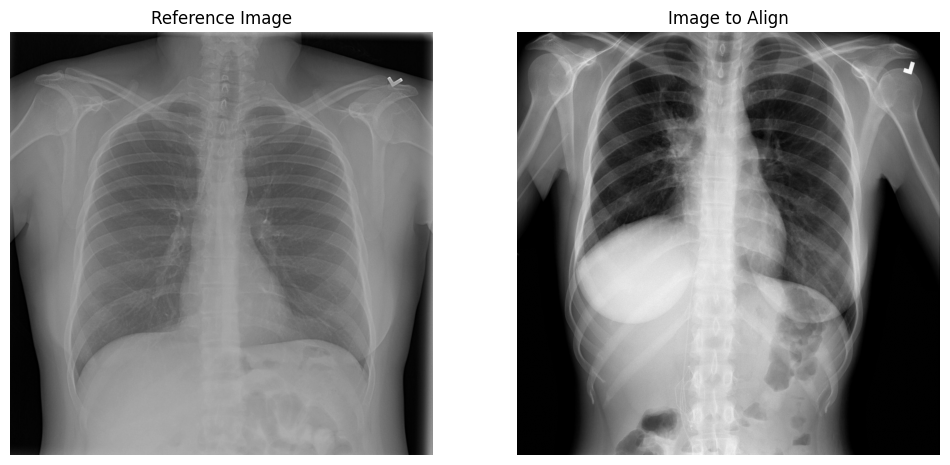

🔄 Running PSO optimization...
Stopping search: maximum iterations reached --> 50

✅ Optimized Parameters:
→ Angle: 3.68°
→ ScaleX: 1.02
→ ScaleY: 1.45
→ Translate X: 26.70
→ Translate Y: 65.12


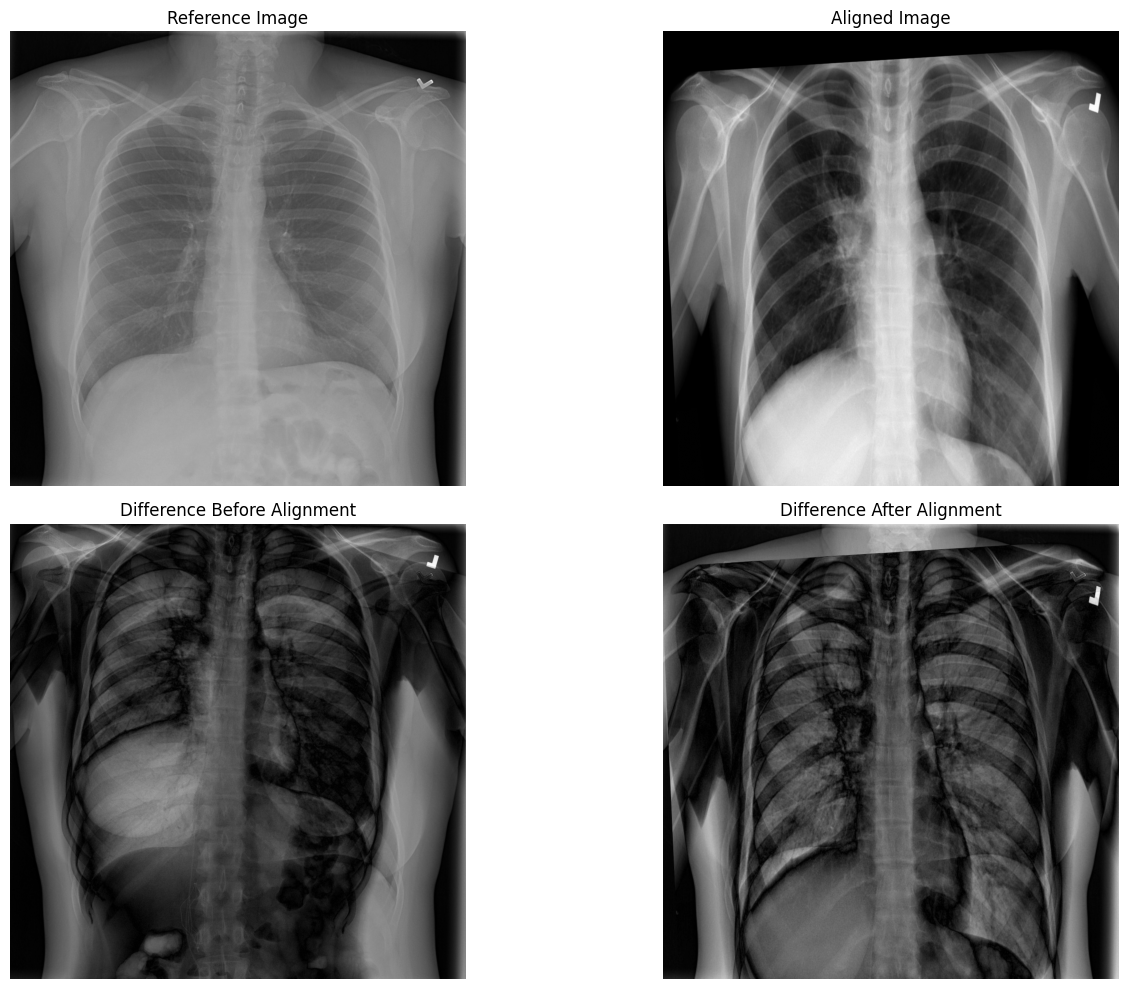

🖼️ Aligned image saved as 'aligned_output.png'


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from pyswarm import pso

# ───── STEP 1: Extract uploaded ZIP file ─────
zip_path = "scan_images.zip"
extract_dir = "scans"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# ───── STEP 2: Load Two Sample Images from the Extracted Folder ─────
def load_sample_images_from_zip(folder):
    # Adjust to look inside 'scans/test' folder
    target_folder = os.path.join(folder, 'Test')
    # Get all image filenames inside 'scans/Test'
    image_files = sorted([
        os.path.join(target_folder, f)
        for f in os.listdir(target_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    if len(image_files) < 2:
        raise ValueError("❌ The folder must contain at least two images!")

    # Read first 2 images
    img1 = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_files[1], cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise FileNotFoundError("❌ Failed to load images from the specified path")

    # Resize if needed
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    return img1, img2

# ───── Load Images ─────
img_ref, img_to_align = load_sample_images_from_zip(extract_dir)

# ───── Display Original Images ─────
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Reference Image")
plt.imshow(img_ref, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Image to Align")
plt.imshow(img_to_align, cmap='gray')
plt.axis('off')
plt.show()

# ───── Objective Function for PSO ─────
def objective_function(params):
    angle, scale_x, scale_y, tx, ty = params
    M = cv2.getRotationMatrix2D((img_ref.shape[1] / 2, img_ref.shape[0] / 2), angle, 1)
    M[0, 0] *= scale_x
    M[1, 1] *= scale_y
    M[0, 2] += tx
    M[1, 2] += ty

    transformed = cv2.warpAffine(img_to_align, M, (img_ref.shape[1], img_ref.shape[0]))

    hist_2d = np.histogram2d(img_ref.ravel(), transformed.ravel(), bins=20)[0]
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return -mi

# ───── Run PSO ─────
lb = [-180, 0.5, 0.5, -100, -100]
ub = [180, 1.5, 1.5, 100, 100]

print("🔄 Running PSO optimization...")
best_params, best_value = pso(objective_function, lb, ub, swarmsize=20, maxiter=50)

print(f"\n✅ Optimized Parameters:")
print(f"→ Angle: {best_params[0]:.2f}°")
print(f"→ ScaleX: {best_params[1]:.2f}")
print(f"→ ScaleY: {best_params[2]:.2f}")
print(f"→ Translate X: {best_params[3]:.2f}")
print(f"→ Translate Y: {best_params[4]:.2f}")

# ───── Apply Optimal Transformation ─────
angle, scale_x, scale_y, tx, ty = best_params
M = cv2.getRotationMatrix2D((img_ref.shape[1] / 2, img_ref.shape[0] / 2), angle, 1)
M[0, 0] *= scale_x
M[1, 1] *= scale_y
M[0, 2] += tx
M[1, 2] += ty

aligned = cv2.warpAffine(img_to_align, M, (img_ref.shape[1], img_ref.shape[0]))

# ───── Show Before & After Differences ─────
difference_before = cv2.absdiff(img_ref, img_to_align)
difference_after = cv2.absdiff(img_ref, aligned)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title("Reference Image")
plt.imshow(img_ref, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Aligned Image")
plt.imshow(aligned, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Difference Before Alignment")
plt.imshow(difference_before, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Difference After Alignment")
plt.imshow(difference_after, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# ───── Save Output ─────
cv2.imwrite('aligned_output.png', aligned)
print("🖼️ Aligned image saved as 'aligned_output.png'")


